In [508]:
import xml.etree.ElementTree as ET
import re
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

plt.rcParams['figure.figsize'] = (12,7)

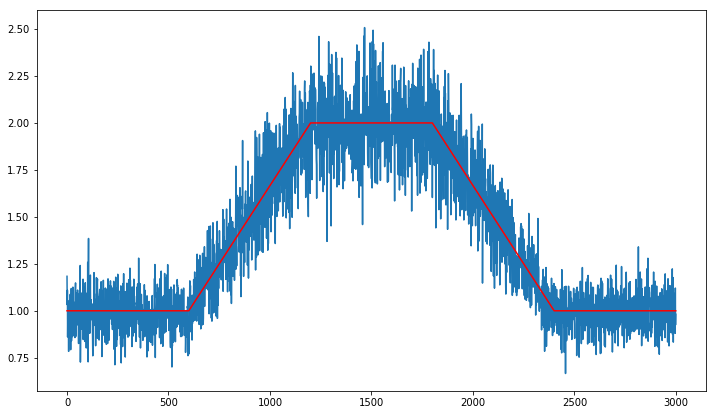

In [509]:
## Tuning demand
def get_veh_sec(x, demand,high, nominal,total_time):
    
    factor = 10

    if demand == "rush":
        part = total_time/5
        if x < part:
            return np.random.normal(nominal, nominal/factor)
        if x < 2*part:
            aux = (nominal-high)/(-part)*x + nominal + (nominal-high)
            return np.random.normal(aux, aux/factor)
        if x < 3*part:
            return np.random.normal(high, high/factor)
        if x < 4*part:
            aux = -(high-nominal)/(part)*x + high+(high-nominal)*3
            return np.random.normal(aux, aux/factor)
        else:
            return np.random.normal(nominal, nominal/factor)
    else:
        return 1
    
def get_veh_sec_wo_rand(x, demand,high, nominal,total_time):
    
    factor = 10

    if demand == "rush":
        part = total_time/5
        if x < part:
            return nominal
        if x < 2*part:
            aux = (nominal-high)/(-part)*x + nominal + (nominal-high)
            return aux
        if x < 3*part:
            return high
        if x < 4*part:
            aux = -(high-nominal)/(part)*x + high+(high-nominal)*3
            return aux
        else:
            return nominal
    else:
        return 1
x = []
y = []
for i in range(3000):
    x.append(get_veh_sec(i, "rush", 2, 1, 3000))
    y.append(get_veh_sec_wo_rand(i, "rush", 2, 1, 3000))
    
plt.plot(x)
plt.plot(y, color = 'r')

## To plot evaluations results

In [510]:
def plot_evaluation(path, labels = None ):
         
    # Bin interval (s)    
    step = 30
    
    N = 3600
       
    runs = re.findall(r'run_\d+',' '.join(os.listdir(path)))
        
    eval_results = pd.DataFrame()
    
    
    
    
    # Second plot
    for run in runs:
    
        run_path = os.path.join(path,run)
        labels = re.findall(r'tripinfo_\w+\.xml',' '.join(os.listdir(run_path)))

        for eval_label in labels:
            
            df = {"run" : [],
                  "depart" : [],
                  "veh_id" : [],
                  "duration" : [],
                  "arrival" : [],
                  "emissions" : []}

            label = re.findall(r'_(\w+).',eval_label)[0]   
            tree = ET.parse(os.path.join(run_path,eval_label))
            root = tree.getroot()          

            for veh in root:
                df["run"].append(run)
                df["veh_id"].append(veh.get("id"))
                df["depart"].append(float(veh.get("depart")))
                df["duration"].append(float(veh.get("duration")))
                df["arrival"].append(float(veh.get("arrival")))
                df["emissions"].append(float(veh[0].get("CO2_abs")))
                
            

            data = pd.DataFrame(df)
            bins = np.arange(start = 0, stop = data.depart.max(), step = step)
            data["interval"] = pd.cut(data.depart, bins= bins, labels = range(len(bins)-1))
            agg_data = data.groupby(data.interval)[["veh_id","duration","emissions"]].agg({"veh_id": lambda x: len(set(x)),'duration': np.sum,'emissions': np.mean})
            label = "fixed" if re.findall(r'fixed',label) else "RL"
            agg_data["label"] = label
            agg_data.reset_index(level=0, inplace=True)
            agg_data["interval"]=agg_data.interval.astype(int)*step#/agg_data.interval.max()

            eval_results = pd.concat([eval_results,agg_data], ignore_index=True)

        # Firt plot

        demand_plot = {"i" : [],
                      "x" : [],
                      "y" : []}

        for i in range(N):
            demand_plot["i"].append(i)
            demand_plot["x"].append(get_veh_sec(i, "rush", 2, 1, N))
            demand_plot["y"].append(get_veh_sec_wo_rand(i, "rush", 2, 1, N))
            
        demand_plot = pd.DataFrame(demand_plot)    

        bins = np.arange(start = 0, stop = N, step = step)
        demand_plot["i"] = pd.cut(demand_plot.i, bins= bins, labels = range(len(bins)-1))
        demand_plot["i"] = demand_plot["i"].astype(int)*step
                       

    fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True)

    sns.lineplot(x = 'i',    
                 y = 'x', 
                 ci = 'sd', 
                 data = demand_plot,
                 legend = False,
                 ax = axes[0],
                 color = 'grey').set_title("Demand");
    
    

    axes[0].set_ylabel("Number of vehicles")

    sns.lineplot(x = 'interval',    
                 y = 'duration', 
                 ci = 'sd', 
                 hue = 'label', 
                 data = eval_results,
                 legend = 'brief',
                 palette = ["coral","royalblue"],
                 ax = axes[1]).set_title("Delay");

    axes[1].set_ylabel("[s]")
    
    return eval_results
    
    #fig.show()

In [511]:
def plot_training(path):
    
    path = os.path.join(path,'GS_results.json')
    
    res = pd.DataFrame()

    with open(path) as file: 
        data = json.load(file) 
        for run in data['results']:
            train_data = pd.DataFrame(run[ "train_data"]) 
            train_data[ "run "] = run[ "run"] 
            res = pd.concat([res,train_data], ignore_index= True) 
            
    ax = sns.lineplot(x = 'ep_id',    
             y = 'av_delay', 
             ci = 'sd', 
             data = res,
             hue = 'label',
             legend = 'brief',
             palette = ["royalblue","coral"])
    
    ax.set_title("Training Delay");
    ax.set_ylabel("[s]")
    ax.set_xlabel("episodes")

In [515]:
# Path of the set of runs
path = "../Experiment_results/Complex_run_4_reproduce"

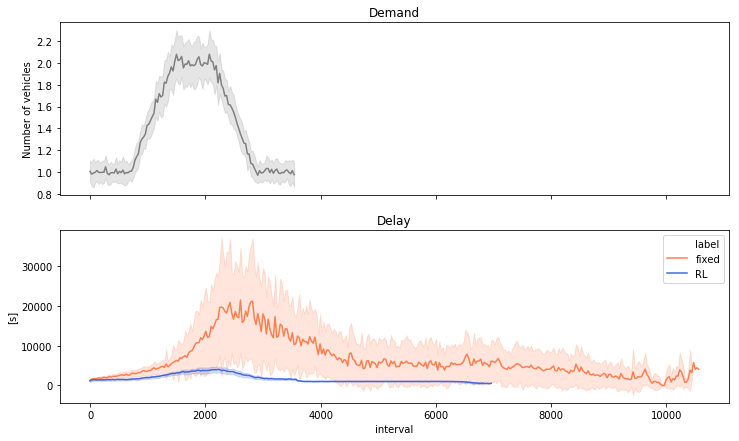

In [516]:
res = plot_evaluation(path)

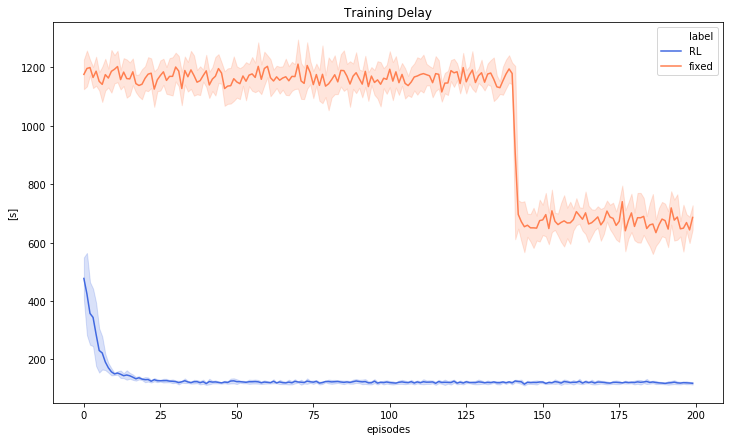

In [517]:
plot_training(path)

In [ ]:

             ,
            evalu.append({\"run\" :run[\"run\"], ,
             \"unfinished\": run['eval_delay']['unfinished_runs'],              ,
             \"RL\" : np.mean(run[\"eval_delay\"][\"episode_mean_delays\"]), ,
            \"fixed\" :np.mean(run[\"eval_delay\"][\"episode_mean_delays_fixed\"])})

Text(17.200000000000003, 0.5, '[s]')

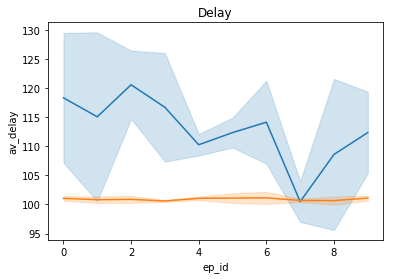

In [275]:
#fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize = (12,7))




# sns.lineplot(x = 'ep_id',    
#              y = 'total_reward', 
#              ci = 'sd', 
#              hue= 'label',
#              data = res,
#              legend = 'brief',
#              ax = axes[1]).set_title("Reward");

# axes[1].set_ylabel("Reward")